<a href="https://colab.research.google.com/github/Jeremiah-Bachtin/comp1884-group6-weather-anomaly-detection-system/blob/main/notebooks/notebook_marie_xai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook contains dashboard ready code for plots and natural language summaries of 3 tested XAI techniques.

1. Tree Path Analysis
2. TreeSHAP
3. Reconstruction Error Attribution

#### Import required python libraries

In [1]:
import tensorflow as tf

print("TensorFlow imported successfully!") # Add a print statement to confirm
print(f"TensorFlow version: {tf.__version__}") # Print version to double-check

TensorFlow imported successfully!
TensorFlow version: 2.10.1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.find_root import find_project_root
import os
from sklearn.ensemble import IsolationForest
from sklearn.tree import _tree
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.client import device_lib
import joblib
from tqdm import tqdm
import time
import random
import shap

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import sklearn
print(sklearn.__version__)

1.4.2


#### Load sequence and inference data

In [6]:
# Retrieve the project root dynamically and set it as working directory
project_root = find_project_root()
os.chdir(project_root)

In [7]:
# seq_start_times = np.load('/content/drive/MyDrive/Data Science MSC/v2XAIHANDOFF/xai_handoff_v2/lstm_sequences/seq_start_times_train.npy',allow_pickle=True)
df = pd.read_csv('outputs/modelling/inference/inference_20250531_1700.csv')

#### Load the Isolation Forest model

In [8]:
if_model = joblib.load('outputs/modelling/models/if_model.joblib')

In [9]:
if_features = ['temperature_2m_z', 'surface_pressure_z', 'wind_r', 'precip_z_12h', 'precip_z_24h']

#### Load the LSTM-Autoencoder model

In [10]:
sequence_data = 'outputs/modelling/inference/lstm_sequences.npy'

# Load the numpy array from the file path into snapshot_df
X = np.load(sequence_data)

# Now you can access the shape of the loaded numpy array
print(X.shape)

(793, 720, 8)


In [11]:
snapshot_data = pd.read_csv('outputs/modelling/inference/inference_20250531_1700.csv')

#### Data exploration

#### Data summary

In [12]:
print(df.head())

                  date  temperature_2m  surface_pressure  precipitation  \
0  2025-05-31 17:00:00            23.0            1011.4            0.0   
1  2025-05-31 18:00:00            21.9            1011.2            0.0   
2  2025-05-31 19:00:00            21.1            1010.8            0.0   
3  2025-05-31 20:00:00            20.1            1010.9            0.0   
4  2025-05-31 21:00:00            18.7            1011.7            0.0   

   wind_speed_10m  precip_log  wind_smoothed  temperature_2m_z  \
0            24.1         0.0      24.100000          1.981413   
1            24.8         0.0      24.450000          1.748538   
2            25.2         0.0      24.700000          1.579173   
3            15.8         0.0      21.933333          1.367468   
4            18.4         0.0      19.800000          1.071081   

   surface_pressure_z    wind_r  ...      hour_cos  month_sin  month_cos  \
0           -0.440185  1.727468  ... -2.588190e-01        0.5  -0.866025   


In [13]:
snapshot_data.head()

,date,temperature_2m,surface_pressure,precipitation,wind_speed_10m,precip_log,wind_smoothed,temperature_2m_z,surface_pressure_z,wind_r,...,hour_cos,month_sin,month_cos,if_score,is_if_anomaly,lstm_error,is_lstm_anomaly,if_threshold,lstm_threshold,anomaly_label
0,2025-05-31 17:00:00,23.0,1011.4,0.0,24.1,0.0,24.100000,1.981413,-0.440185,1.727468,...,-2.588190e-01,0.5,-0.866025,0.162669,0,0.680835,1,0.033044,0.6425,Pattern anomaly
1,2025-05-31 18:00:00,21.9,1011.2,0.0,24.8,0.0,24.450000,1.748538,-0.467940,1.772532,...,-1.836970e-16,0.5,-0.866025,0.169193,0,0.644328,1,0.033044,0.6425,Pattern anomaly
2,2025-05-31 19:00:00,21.1,1010.8,0.0,25.2,0.0,24.700000,1.579173,-0.523450,1.804721,...,2.588190e-01,0.5,-0.866025,0.167394,0,0.668963,1,0.033044,0.6425,Pattern anomaly
3,2025-05-31 20:00:00,20.1,1010.9,0.0,15.8,0.0,21.933333,1.367468,-0.509572,1.448498,...,5.000000e-01,0.5,-0.866025,0.200375,0,0.507134,0,0.033044,0.6425,Normal
4,2025-05-31 21:00:00,18.7,1011.7,0.0,18.4,0.0,19.800000,1.071081,-0.398553,1.173820,...,7.071068e-01,0.5,-0.866025,0.234645,0,0.508397,0,0.033044,0.6425,Normal


#### Loading the autoencoder

In [15]:
autoencoder = load_model("outputs/modelling/models/lstm_ae_best.h5")

## XAI Technique 1: Tree Path Analysis

Tree structure

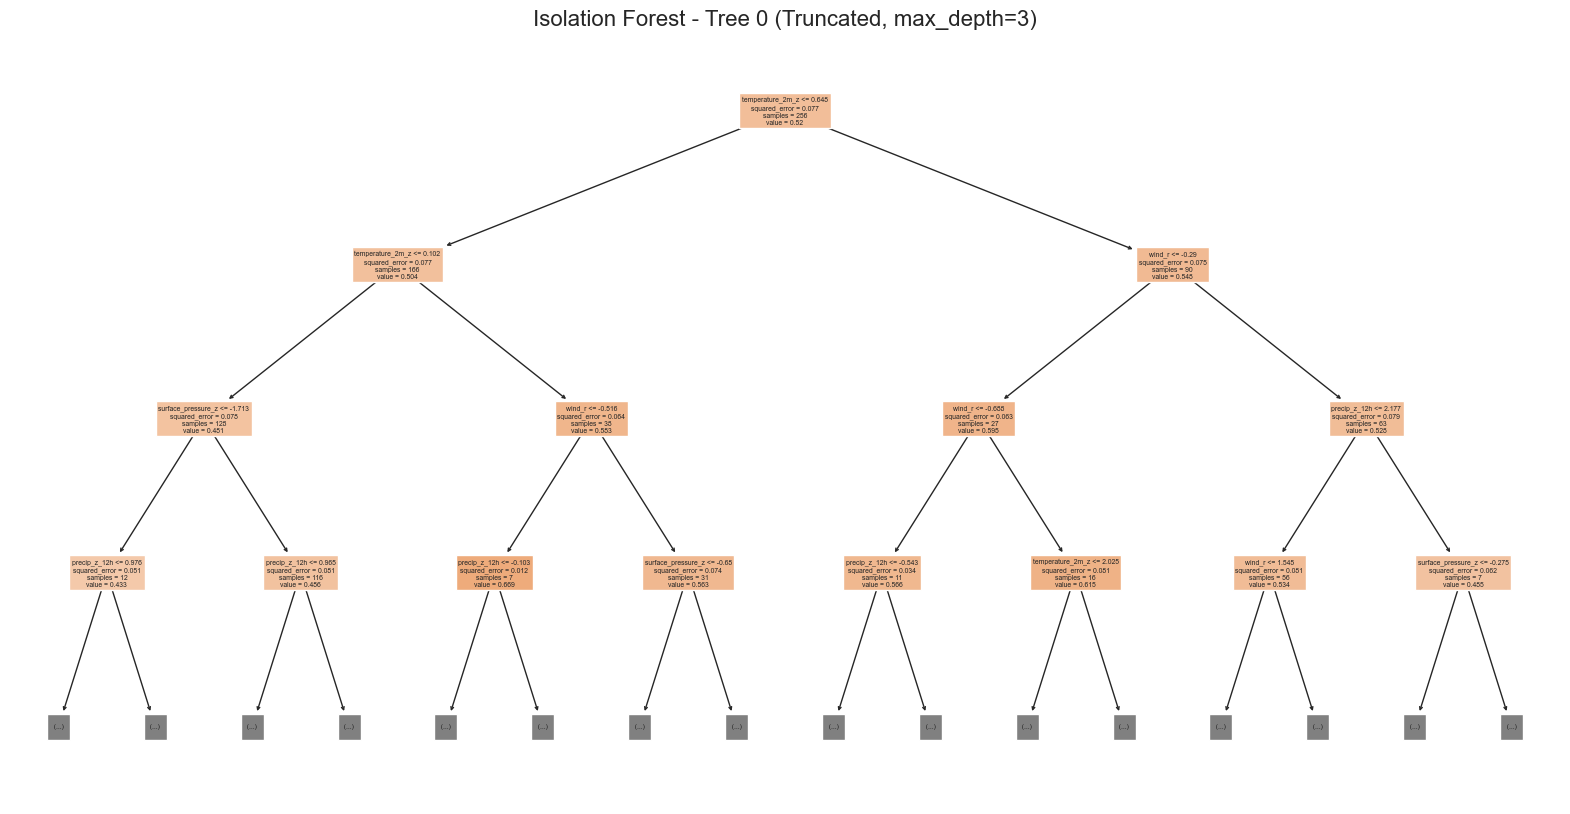

In [16]:
tree_index_to_plot = 0 # first tree in the ensemble- change index to change which tree is visualisaed

if tree_index_to_plot < len(if_model.estimators_):
    selected_tree = if_model.estimators_[tree_index_to_plot]

    plt.figure(figsize=(20, 10))
    plot_tree(selected_tree, feature_names=if_features, filled=True, max_depth=3)  # Limit max_depth for readability

    plt.title(f"Isolation Forest - Tree {tree_index_to_plot} (Truncated, max_depth=3)", fontsize=16)
    plt.show()
else:
    print(f"Error: Tree index {tree_index_to_plot} is out of bounds. The model has {len(if_model.estimators_)} trees (indices 0 to {len(if_model.estimators_)-1}).")


Path length of a single sample

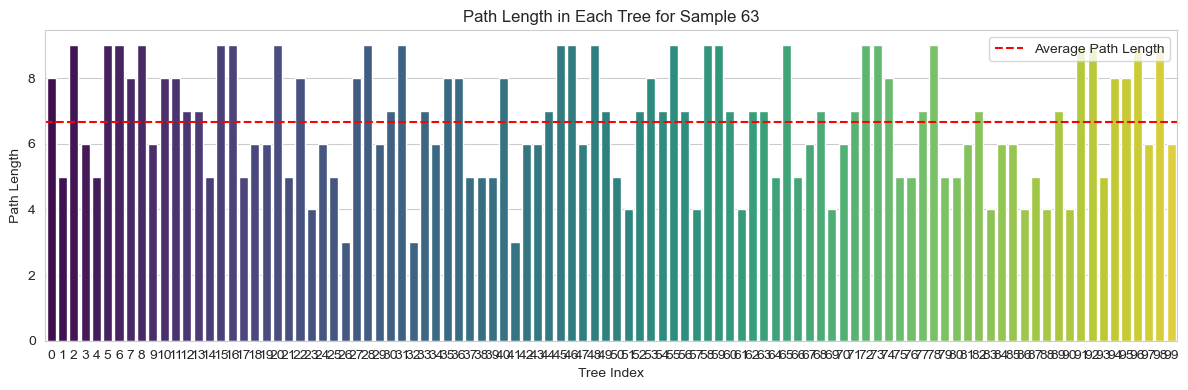

In [17]:
sample_index = 63 # change to select a different sample

# Select the sample data for the Isolation Forest features
X_sample = df[if_features].iloc[[sample_index]]

# Calculate the path length for this sample in each tree
path_lengths = []
for tree in if_model.estimators_:
    # tree.decision_path returns a sparse matrix indicating the path nodes
    path = tree.decision_path(X_sample)
    # number of nodes visited (number of non-zero entries in the sparse matrix)
    path_lengths.append(path.nnz)

# Now path_lengths is defined and contains the path length for the sample in each tree

plt.figure(figsize=(12, 4))
sns.barplot(x=np.arange(len(path_lengths)), y=path_lengths, palette="viridis")
plt.axhline(np.mean(path_lengths), color='red', linestyle='--', label='Average Path Length')
plt.xlabel("Tree Index")
plt.ylabel("Path Length")
plt.title(f"Path Length in Each Tree for Sample {sample_index}")
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# calculating and storing decision paths for each sample through each tree in the Isolation Forest
paths_per_tree = []

for tree in if_model.estimators_:

    snapshot_df = df[if_features]
    path_matrix_tree = tree.decision_path(snapshot_df)
    paths_per_tree.append(path_matrix_tree)

print(f"Number of trees processed: {len(paths_per_tree)}")
print(f"Shape of path matrix for the first tree: {paths_per_tree[0].shape}")

Number of trees processed: 100
Shape of path matrix for the first tree: (72, 169)


In [19]:
# identifying which features were used in splits

def tree_path_features(tree, x):
    tree_ = tree.tree_
    feature = tree_.feature
    threshold = tree_.threshold

    node = 0
    path_features = []

    while tree_.feature[node] != _tree.TREE_UNDEFINED:
        split_feature = feature[node]
        path_features.append(split_feature)
        if x[split_feature] <= threshold[node]:
            node = tree_.children_left[node]
        else:
            node = tree_.children_right[node]

    return path_features


### XAI visualisations & natural language summaries

Feature importance


Represents how frequently each feature was used for splitting decisions along paths taken by analyzed samples

In [20]:
# calculating and visualising TPA scores for each sample in the snapshot

# Dictionary to store feature counts for each sample
all_sample_feature_counts = {}

for i, row in snapshot_df.iterrows():
    # Dictionary to store feature counts for the current sample
    feature_counts = {}

    # Iterate through each tree in the Isolation Forest model
    for estimator in if_model.estimators_:
        features_used = tree_path_features(estimator, row[if_features].values)

        # Count how many times each feature's index was used in the path
        for f in features_used:

            fname = if_features[f]
            feature_counts[fname] = feature_counts.get(fname, 0) + 1

    # Store the feature counts for the current sample, indexed by the original sample index
    all_sample_feature_counts[i] = feature_counts

# Convert the dictionary of feature counts into a DataFrame
# Each row corresponds to a sample (original index), columns are features, values are counts
tpa_df = pd.DataFrame.from_dict(all_sample_feature_counts, orient='index')

tpa_df = tpa_df.fillna(0)

# Normalize the counts: Divide the counts for each feature by the total number of trees
# This gives the proportion of trees where a feature was used in the sample's path
tpa_df = tpa_df / len(if_model.estimators_)



Generating natural language summaries and visualisations for each sample based on TPA scores

In [23]:


# Define output directory for plots
plot_output_dir = "outputs/xai/plots"
# os.makedirs(plot_output_dir, exist_ok=True)

# Initialize lists to hold summaries and plot file paths
tpa_summaries = []
tpa_plot_paths = []

for original_sample_index in snapshot_df.index:

    label = df.loc[original_sample_index, "anomaly_label"]

    if label.lower() == "compound anomaly":
        label_description = (
            "🔺 This sample was flagged as a **Compound Anomaly**, meaning both sub-models detected unusual patterns. "
            "This may suggest a more credible anomaly, but should still be reviewed in context."
        )
        what_happened = (
            "The sample exhibits multiple unusual characteristics detected by both models."
        )
        why_happened = (
            "The combined flags indicate consistent unusual activity across different feature subsets."
        )
        what_to_do = (
            "Consider prioritizing this sample for further investigation or mitigation."
        )
    elif label.lower() == "normal":
        label_description = (
            "✅ This sample was classified as **Normal**, meaning the model found no significant deviations in the data."
        )
        what_happened = "The sample shows normal behavior with no flagged anomalies."
        why_happened = "The features fell within expected ranges based on training data."
        what_to_do = "No immediate action is required."
    else:
        label_description = (
            f"⚠️ This sample was labeled as **{label}**, flagged by only one detection model."
        )
        what_happened = (
            "The model identified some unusual patterns but only from a single perspective."
        )
        why_happened = (
            "This could be due to isolated irregularities or potential model sensitivity."
        )
        what_to_do = (
            "Further review is advised to confirm whether this is a true anomaly."
        )

    if original_sample_index in tpa_df.index:
        sample_tpa_scores = tpa_df.loc[original_sample_index]
        sample_tpa_scores_sorted = sample_tpa_scores.sort_values(ascending=False)

        # Generate summary text
        top_features = sample_tpa_scores_sorted.head(2)
        summary = (
            f"🧠 Tree Path Analysis shows these top features influenced the model's decision:\n"
        )
        for feature, score in top_features.items():
            summary += f"- **{feature.replace('_', ' ').capitalize()}** (importance: {score:.2f})\n"

        summary += (
            f"\nWhat happened?\n{what_happened}\n\n"
            f"Why did it happen?\n{why_happened}\n\n"
            f"What can we do about it?\n{what_to_do}\n\n"
            f"{label_description}"
        )

        # Save summary text for this sample
        tpa_summaries.append(summary)

        # Create and save plot
        plt.figure(figsize=(10, 6))
        sample_tpa_scores_sorted.plot(kind="barh", color="teal")
        plt.title(f"Tree Path Analysis\nSample Index: {original_sample_index} | Label: {label}", fontsize=14)
        plt.xlabel("Normalized Split Count (Across Trees)", fontsize=12)
        plt.ylabel("Feature", fontsize=12)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()

        plot_filename = f"tpa_sample_{original_sample_index}.png"
        plot_filepath = os.path.join(plot_output_dir, plot_filename)
        plt.savefig(plot_filepath)
        plt.close()

        tpa_plot_paths.append(plot_filepath)

    else:
        print(f"⚠️ Error: Sample index {original_sample_index} not found in TPA results.")
        tpa_summaries.append("")
        tpa_plot_paths.append("")

# Append new columns to snapshot data
df.loc[snapshot_df.index, "tpa_summary"] = tpa_summaries
df.loc[snapshot_df.index, "tpa_plot_path"] = tpa_plot_paths

# Save to CSV
output_csv_path = "outputs/xai/TPA.csv"
df.to_csv(output_csv_path, index=False)
print(f"✅ Updated CSV saved to: {output_csv_path}")


✅ Updated CSV saved to: outputs/xai/TPA.csv


## XAI Technique 2: TreeSHAP

Global overview of feature importance

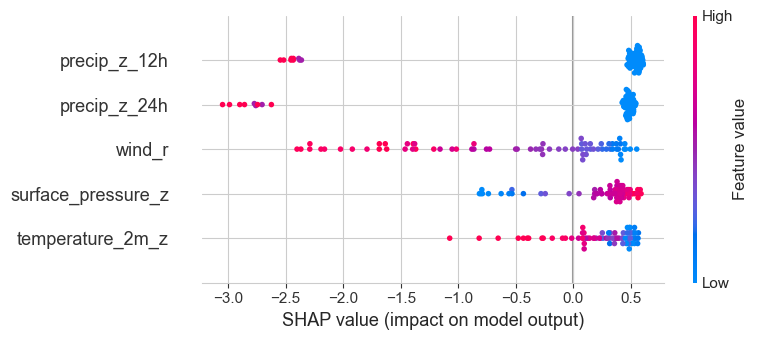

In [24]:
X_if = df[if_features]

explainer = shap.TreeExplainer(if_model)

shap_values = explainer.shap_values(X_if)

shap.summary_plot(shap_values, X_if)

Average SHAP value for each feature

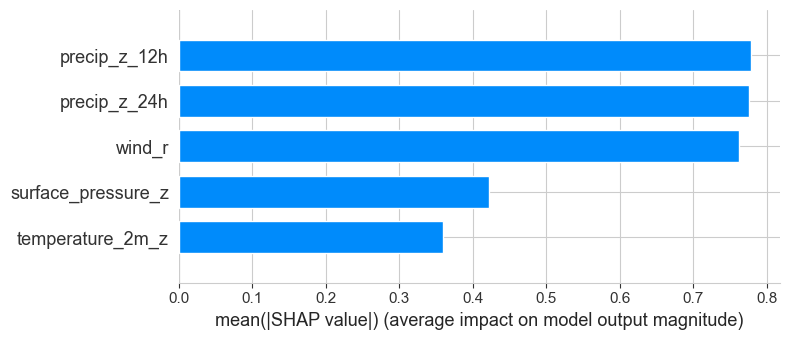

In [25]:
shap.summary_plot(shap_values, X_if, plot_type="bar")


Feature dependence plots

Generating dependence plot for feature: temperature_2m_z


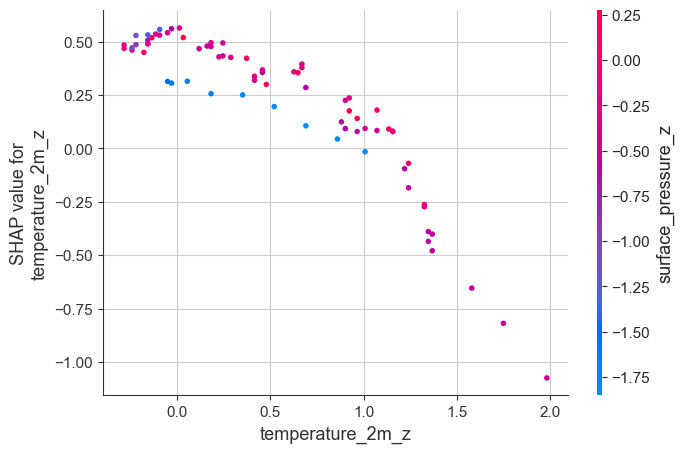

Generating dependence plot for feature: surface_pressure_z


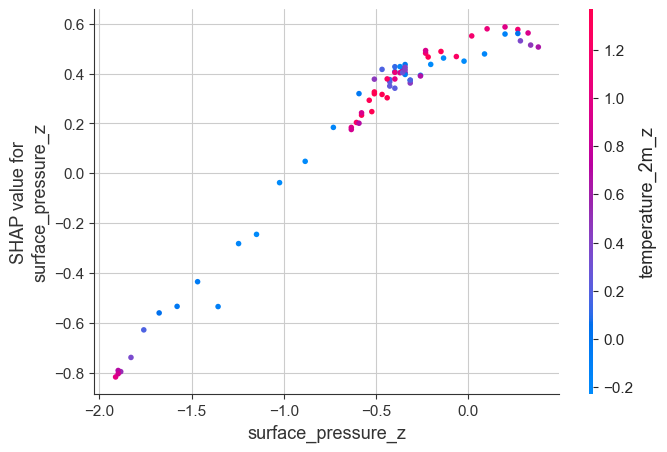

Generating dependence plot for feature: wind_r


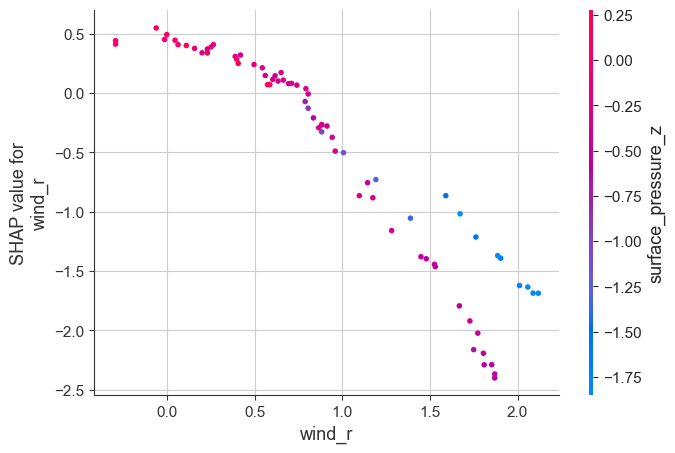

Generating dependence plot for feature: precip_z_12h


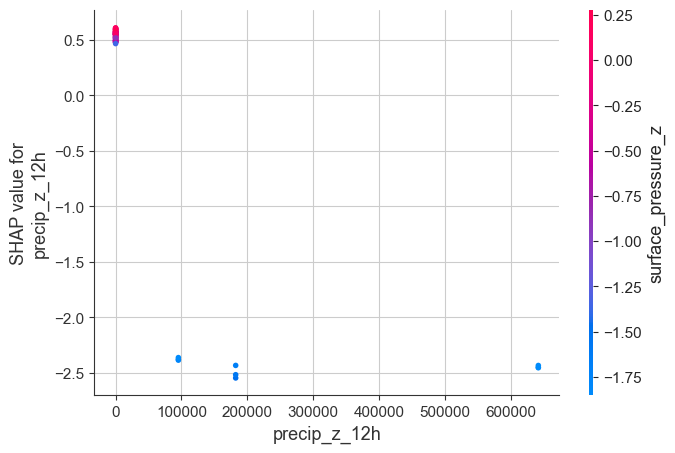

Generating dependence plot for feature: precip_z_24h


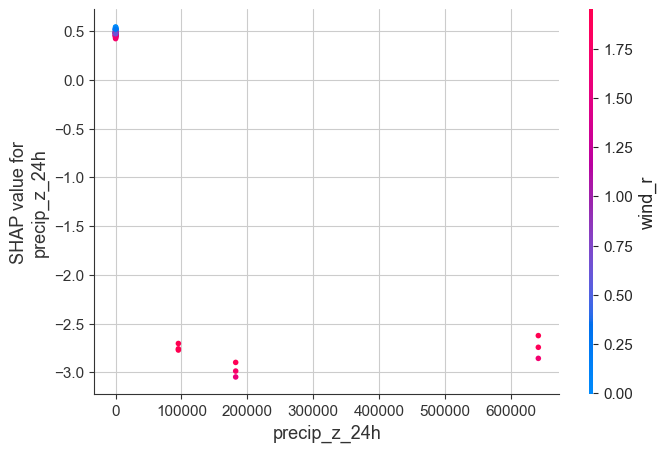

In [26]:
for feature_name in if_features:
    print(f"Generating dependence plot for feature: {feature_name}")


    shap.dependence_plot(
        feature_name,
        shap_values,
        X_if
    )

    plt.show()

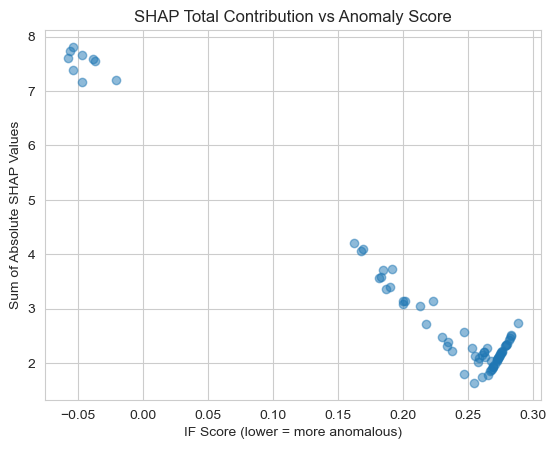

In [27]:
if_scores = if_model.decision_function(X_if)

df.loc[X_if.index, "if_score"] = if_scores

import matplotlib.pyplot as plt

total_shap = np.abs(shap_values).sum(axis=1)

plt.scatter(df.loc[X_if.index, "if_score"], total_shap, alpha=0.5)
plt.xlabel("IF Score (lower = more anomalous)")
plt.ylabel("Sum of Absolute SHAP Values")
plt.title("SHAP Total Contribution vs Anomaly Score")
plt.show()

## Global summmary

In [28]:
mean_abs_shap = np.abs(shap_values).mean(axis=0)
global_explainer = pd.DataFrame({
    "feature": if_features,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

In [29]:
top_global = global_explainer.head(3)

global_summary = "Across the dataset, the model considered the following features most important for detecting anomalies:\n"
for _, row in top_global.iterrows():
    global_summary += f"- {row['feature']}, with average contribution magnitude of {row['mean_abs_shap']:.4f}\n"

print(global_summary)

Across the dataset, the model considered the following features most important for detecting anomalies:
- precip_z_12h, with average contribution magnitude of 0.7794
- precip_z_24h, with average contribution magnitude of 0.7766
- wind_r, with average contribution magnitude of 0.7624



## Local Explanation (specific data points)

In [30]:
X_shap = df[if_features]

Generating force plot for sample with index: 63


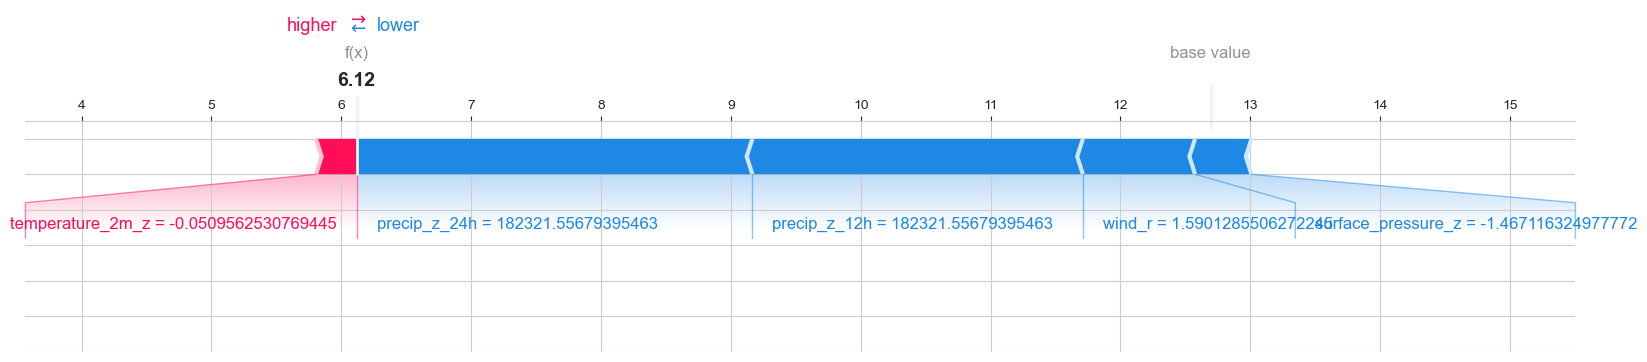

In [31]:
shap.initjs()


sample_index = 63

# Check if the sample index exists in the DataFrame
if sample_index in df.index:
    # Get the corresponding SHAP values for the selected sample
    # Use get_loc to find the integer position in the shap_values array
    sample_shap_index = df.index.get_loc(sample_index)
    current_shap_values = shap_values[sample_shap_index]

    # Get the actual feature values for the selected sample
    current_feature_values = X_if.loc[sample_index]

    print(f"Generating force plot for sample with index: {sample_index}")

    # Generate and display the force plot for the selected sample
    shap.force_plot(
        explainer.expected_value[0],
        current_shap_values,
        current_feature_values,
        matplotlib=True
    )

    plt.show()
else:
    print(f"Sample index {sample_index} not found in the DataFrame.")

Generating waterfall plot for sample with index: 63


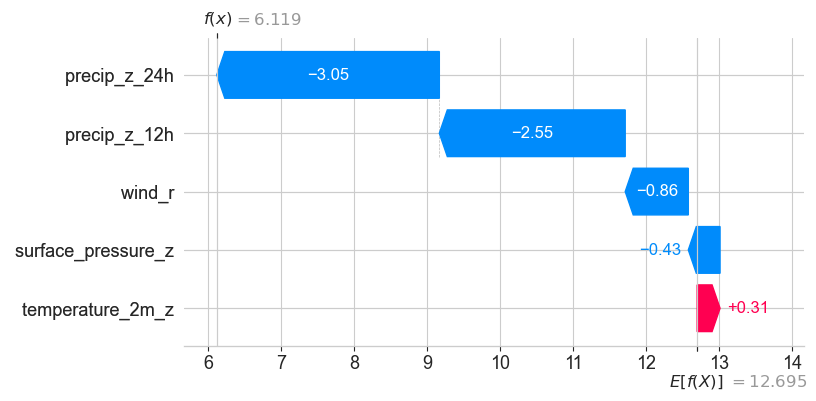

In [32]:

sample_index_to_plot = 63

# Check if the sample index exists in the DataFrame
if sample_index_to_plot in df.index:
    # Get the corresponding SHAP values for the selected sample
    # Use get_loc to find the integer position in the shap_values array
    sample_shap_index = df.index.get_loc(sample_index_to_plot)
    current_shap_values = shap_values[sample_shap_index]

    # Get the actual feature values for the selected sample
    current_feature_values = X_if.loc[sample_index_to_plot]

    print(f"Generating waterfall plot for sample with index: {sample_index_to_plot}")

    # Generate and display the waterfall plot for the selected sample
    shap.plots._waterfall.waterfall_legacy(
        explainer.expected_value[0],
        current_shap_values,
        current_feature_values
    )

    plt.show()
else:
    print(f"Sample index {sample_index_to_plot} not found in the DataFrame.")

Generating local feature contribution visualisations and natural language summaries for each sample

In [33]:
def plot_local_contribution(shap_values_sample, feature_values_sample, feature_names, anomaly_label, save_path=None):
    plt.figure(figsize=(10, 6))
    abs_shap = np.abs(shap_values_sample)
    sorted_indices = np.argsort(abs_shap)[::-1]
    sorted_features = np.array(feature_names)[sorted_indices]
    sorted_shap_values = shap_values_sample[sorted_indices]
    colors = ['#FF9999' if val < 0 else '#6699FF' for val in sorted_shap_values]
    plt.bar(sorted_features, sorted_shap_values, color=colors)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("SHAP value")
    plt.title(f"SHAP Local Contribution\nLabel: {anomaly_label}")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

In [34]:
def generate_formatted_summary(expected_value, shap_values_sample, feature_values_sample, feature_names, anomaly_label):
    """
    Generates a natural language summary for a single sample's SHAP explanation.

    Args:
        expected_value: The baseline/expected value from the SHAP explainer.
        shap_values_sample: The SHAP values for the specific sample.
        feature_values_sample: The feature values for the specific sample.
        feature_names: A list of the feature names.
        anomaly_label: The anomaly label for the sample.

    Returns:
        A formatted string summary.
    """
    summary_parts = []

    # Add anomaly label description
    if anomaly_label.lower() == "compound anomaly":
        label_description = "🔺 **Compound Anomaly**: Both sub-models detected unusual patterns."
    elif anomaly_label.lower() == "normal":
        label_description = "✅ **Normal**: No significant deviations found."
    else:
        label_description = f"⚠️ **{anomaly_label}**: Flagged by one detection model."

    summary_parts.append(label_description)
    summary_parts.append("\n🧠 SHAP Explanation:")

    # Sort features by absolute SHAP value to highlight most impactful ones
    abs_shap = np.abs(shap_values_sample)
    sorted_indices = np.argsort(abs_shap)[::-1]
    sorted_features = np.array(feature_names)[sorted_indices]
    sorted_shap = shap_values_sample[sorted_indices]
    sorted_values = feature_values_sample.values[sorted_indices] # Get corresponding feature values

    summary_parts.append(f"Model baseline (average expected score): {expected_value:.4f}")
    summary_parts.append(f"Sample score deviation: {np.sum(sorted_shap):.4f}") # Sum of SHAP values should approximate score - baseline

    summary_parts.append("\nKey features contributing to the score:")
    # Iterate through top features (e.g., top 5)
    for i in range(min(len(sorted_features), 5)): # Take top 5 or fewer if available
        feature = sorted_features[i]
        shap_val = sorted_shap[i]
        feature_val = sorted_values[i]

        contribution = "increasing" if shap_val > 0 else "decreasing"
        direction = "positive" if feature_val > 0 else "negative" if feature_val < 0 else "zero"
        significance = "significantly" if abs(shap_val) > abs(expected_value)/len(feature_names) else "" # simple heuristic

        summary_parts.append(
            f"- **{feature.replace('_', ' ').capitalize()}** (value: {feature_val:.2f}) {significance} contributed to the score with a SHAP value of {shap_val:.4f}."
        )

    # Add general interpretations based on anomaly label (can be more sophisticated)
    if anomaly_label.lower() == "compound anomaly":
         summary_parts.append(
            "\nInterpretation:\n"
            "This sample's features caused a notable deviation from the expected baseline. The combined flags across models suggest robust evidence of an anomaly."
         )
    elif anomaly_label.lower() == "normal":
         summary_parts.append(
            "\nInterpretation:\n"
            "The feature contributions balance out, resulting in a score close to the baseline, consistent with normal behavior."
         )
    else:
         summary_parts.append(
            "\nInterpretation:\n"
            "While flagged by one model, the SHAP values show which features pushed the score away from the baseline. Review these features to understand the potential anomaly."
         )


    return "\n".join(summary_parts)

In [37]:
# Define output directory for plots
plot_output_dir = "outputs/xai/plots"
os.makedirs(plot_output_dir, exist_ok=True) # Ensure directory exists

# Initialize lists to hold summaries and plot file paths
shap_summaries = []
shap_plot_paths = []

# Assuming X_if is the DataFrame subset used for SHAP calculation (which it is in your code)
# explainer should also be defined before this loop

for index, row in X_if.iterrows():
    # Get the anomaly label for the current sample from the original df
    anomaly_label = df.loc[index, "anomaly_label"]

    # Get SHAP values for the current sample
    # We need to find the corresponding SHAP values based on the index
    # Assuming the order of rows in X_if matches the order in shap_values
    sample_shap_index = X_if.index.get_loc(index)
    current_shap_values = shap_values[sample_shap_index]
    current_feature_values = row # The row itself contains the feature values for X_if

    # Generate the summary for the current sample
    summary = generate_formatted_summary(
        explainer.expected_value[0], # Assuming expected_value is a list/array, take the first element
        current_shap_values,
        current_feature_values,
        if_features, # Use the correct list of feature names
        anomaly_label
    )
    shap_summaries.append(summary)

    # Generate and save the plot for the current sample
    plot_filename = f"treeshap_sample_{index}.png"
    plot_filepath = os.path.join(plot_output_dir, plot_filename)

    plot_local_contribution(
        current_shap_values,
        current_feature_values,
        if_features, # Use the correct list of feature names
        anomaly_label,
        save_path=plot_filepath # Save the plot to the specified path
    )
    shap_plot_paths.append(plot_filepath)


# Save to CSV
output_csv_path = "outputs/xai/treeshap.csv"
df.to_csv(output_csv_path, index=False)
print(f"✅ Updated CSV saved to: {output_csv_path}")

✅ Updated CSV saved to: outputs/xai/treeshap.csv


### XAI technique 3: Reconstruction Error Attribution

In [38]:

# Convert X to float32
X = np.array(X, dtype=np.float32)

# Predict the reconstruction using the loaded autoencoder model
# This is where X_reconstructed is first defined
X_reconstructed = autoencoder.predict(X)

# Now convert X_reconstructed to float32 (although predict usually returns float32)
# This line can now execute without NameError as X_reconstructed is defined
X_reconstructed = np.array(X_reconstructed, dtype=np.float32)

print("X and X_reconstructed are now defined and converted.")
print(f"Shape of X: {X.shape}, Dtype: {X.dtype}")
print(f"Shape of X_reconstructed: {X_reconstructed.shape}, Dtype: {X_reconstructed.dtype}")

25/25 [==============================] - 17s 80ms/step
X and X_reconstructed are now defined and converted.
Shape of X: (793, 720, 8), Dtype: float32
Shape of X_reconstructed: (793, 720, 8), Dtype: float32


25/25 [==============================] - 2s 80ms/step


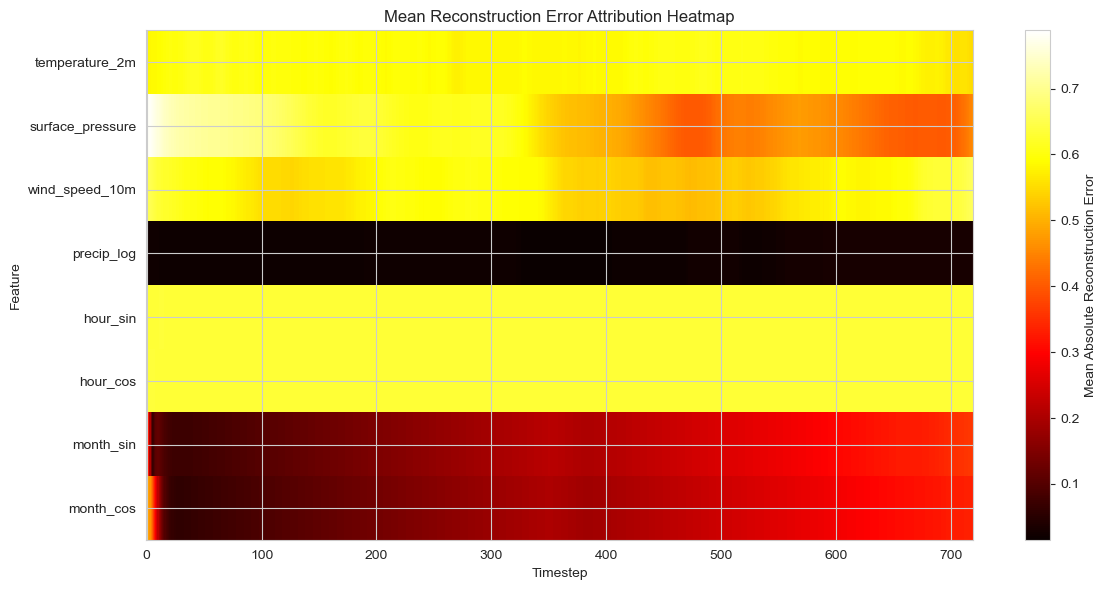

In [39]:

# 1. Predict reconstruction
X_reconstructed = autoencoder.predict(X)

# 2. Compute reconstruction error (element-wise absolute difference)
# Shape: (793, 720, 8)
reconstruction_error = np.abs(X - X_reconstructed)

# Optional: average over all samples to get mean error per timestep and feature
# Shape: (720, 8)
mean_error = np.mean(reconstruction_error, axis=0)

# 3. Visualize as heatmap (time on x-axis, features on y-axis)
plt.figure(figsize=(12, 6))
plt.title("Mean Reconstruction Error Attribution Heatmap")
plt.xlabel("Timestep")
plt.ylabel("Feature")

required_features = [
    'temperature_2m', 'surface_pressure', 'wind_speed_10m', 'precip_log',
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos'
]

if len(required_features) == mean_error.shape[1]:
    plt.yticks(np.arange(len(required_features)), required_features)
else:
    plt.yticks(np.arange(mean_error.shape[1]), [f"Feature {i}" for i in range(mean_error.shape[1])])
    print("Warning: Could not use required_features for y-axis labels. Check number of features.")

# Transpose so features are on y-axis and timesteps on x-axis
plt.imshow(mean_error.T, aspect='auto', cmap='hot', interpolation='nearest')
plt.colorbar(label='Mean Absolute Reconstruction Error')
plt.tight_layout()
plt.show()

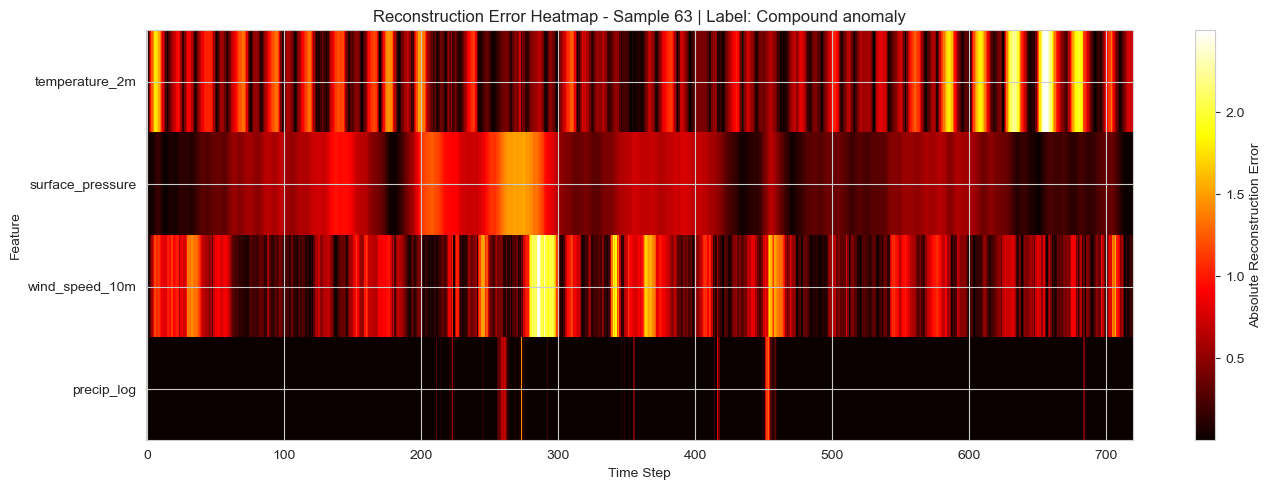


📝 Explanation for Sample 63 (Label: Compound anomaly):

🔍 **Anomaly Severity**: Potential weather anomaly (multiple detection methods agree)

⚠️ The model flagged this sample as **anomalous** based on unusual reconstruction behavior.

📌 **What this means:**
This time window exhibited deviations from typical weather patterns, which may indicate unexpected events or data irregularities.

🛠️ **Recommended action:** Consider reviewing operational context (e.g., weather warnings, sudden shifts in conditions) for this period.

----------------------------------------------------------------------------------------------------



In [41]:
# Load anomaly labels
csv_path = "outputs/modelling/inference/inference_20250531_1700.csv"
anomaly_labels_all = pd.read_csv(csv_path)["anomaly_label"]

# Selected features and their indices
selected_features = ['temperature_2m', 'surface_pressure', 'wind_speed_10m', 'precip_log']
required_features = [
    'temperature_2m', 'surface_pressure', 'wind_speed_10m', 'precip_log',
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos'
]
selected_indices = [required_features.index(f) for f in selected_features]

# Severity mapping for human-readable labels
severity_mapping = {
    "normal": "No concern",
    "point anomaly": "Minor deviation (single-point irregularity)",
    "pattern anomaly": "Unusual behavior (pattern-level issue)",
    "compound anomaly": "Potential weather anomaly (multiple detection methods agree)"
}

# Explanation generator based only on anomaly label
def generate_explanation(label="normal"):
    severity_description = severity_mapping.get(label.lower(), "Unknown anomaly severity")

    summary = f"🔍 **Anomaly Severity**: {severity_description}\n"

    if label.lower() == "normal":
        summary += (
            "\n✅ No anomalies were detected in this sample. Model predictions were consistent with expected weather patterns.\n"
            "No action is required for this time window."
        )
    else:
        summary += (
            "\n⚠️ The model flagged this sample as **anomalous** based on unusual reconstruction behavior.\n"
            "\n📌 **What this means:**\n"
            "This time window exhibited deviations from typical weather patterns, which may indicate unexpected events or data irregularities.\n"
            "\n🛠️ **Recommended action:** Consider reviewing operational context (e.g., weather warnings, sudden shifts in conditions) for this period."
        )

    return summary

# Specify the single sample index you want to analyze
sample_index = 63 # Change this to the desired sample index

# 🛡️ Label check for the specific sample
if sample_index >= len(anomaly_labels_all):
    print(f"Skipping sample {sample_index} — no label found.")
else:
    sample_label = anomaly_labels_all.iloc[sample_index]

    # Plot heatmap of reconstruction error for selected features
    sample_error = reconstruction_error[sample_index]
    selected_error = sample_error[:, selected_indices]

    plt.figure(figsize=(14, 5))
    plt.title(f"Reconstruction Error Heatmap - Sample {sample_index} | Label: {sample_label}")
    plt.xlabel("Time Step")
    plt.ylabel("Feature")
    plt.imshow(selected_error.T, aspect='auto', cmap='hot', interpolation='nearest')
    plt.yticks(np.arange(len(selected_features)), selected_features)
    plt.colorbar(label='Absolute Reconstruction Error')
    plt.tight_layout()
    plt.show()

    # Generate and print explanation based on anomaly label only
    explanation = generate_explanation(label=sample_label)
    print(f"\n📝 Explanation for Sample {sample_index} (Label: {sample_label}):\n")
    print(explanation)
    print("\n" + "-" * 100 + "\n")

Exports

In [42]:
# Output directory for REA plots
output_dir_rea = "outputs/xai/plots"
os.makedirs(output_dir_rea, exist_ok=True)

selected_features = ['temperature_2m', 'surface_pressure', 'wind_speed_10m', 'precip_log']
required_features = [
    'temperature_2m', 'surface_pressure', 'wind_speed_10m', 'precip_log',
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos'
]
selected_indices = [required_features.index(f) for f in selected_features]

severity_mapping = {
    "normal": "No concern",
    "point anomaly": "Minor deviation (single-point irregularity)",
    "pattern anomaly": "Unusual behavior (pattern-level issue)",
    "compound anomaly": "Potential weather anomaly (multiple detection methods agree)"
}

def generate_explanation(label="normal"):
    severity_description = severity_mapping.get(label.lower(), "Unknown anomaly severity")

    summary = f"🔍 **Anomaly Severity**: {severity_description}\n"

    if label.lower() == "normal":
        summary += (
            "\n✅ No anomalies were detected in this sample. Model predictions were consistent with expected weather patterns.\n"
            "No action is required for this time window."
        )
    else:
        summary += (
            "\n⚠️ The model flagged this sample as **anomalous** based on unusual reconstruction behavior.\n"
            "\n📌 **What this means:**\n"
            "This time window exhibited deviations from typical weather patterns, which may indicate unexpected events or data irregularities.\n"
            "\n🛠️ **Recommended action:** Consider reviewing operational context (e.g., weather warnings, sudden shifts in conditions) for this period."
        )

    return summary


# Prepare lists for REA results
rea_summaries = []
rea_plot_paths = []
dates_list = []

num_samples = reconstruction_error.shape[0]

for sample_index in range(num_samples):
    if sample_index >= len(anomaly_labels_all):
        print(f"Skipping sample {sample_index} — no label found.")
        continue

    sample_label = anomaly_labels_all.iloc[sample_index]

    # Get date for this sample_index (ensure df index aligns or adapt as needed)
    if sample_index not in df.index:
        print(f"Sample index {sample_index} not in df.index. Skipping.")
        continue
    date_value = df.loc[sample_index, "date"]

    # Extract selected reconstruction error features for plotting
    sample_error = reconstruction_error[sample_index]
    selected_error = sample_error[:, selected_indices]

    plt.figure(figsize=(14, 5))
    plt.title(f"Reconstruction Error Heatmap - Sample {sample_index} | Label: {sample_label}")
    plt.xlabel("Time Step")
    plt.ylabel("Feature")
    plt.imshow(selected_error.T, aspect='auto', cmap='hot', interpolation='nearest')
    plt.yticks(np.arange(len(selected_features)), selected_features)
    plt.colorbar(label='Absolute Reconstruction Error')
    plt.tight_layout()

    # Safe filename based on date
    safe_date_str = pd.to_datetime(date_value).strftime("%Y%m%d_%H%M%S")
    plot_filename = f"rea_plot_{safe_date_str}.png"
    plot_path = os.path.join(output_dir_rea, plot_filename)

    plt.savefig(plot_path)
    plt.close()

    explanation = generate_explanation(label=sample_label)

    dates_list.append(date_value)
    rea_summaries.append(explanation)
    rea_plot_paths.append(plot_path)

    print(f"Processed REA Sample {sample_index} - Date: {date_value}")

# Create DataFrame for REA results
rea_results_df = pd.DataFrame({
    'date': dates_list,
    'rea_summary': rea_summaries,
    'rea_plot_path': rea_plot_paths
})


# Ensure both date columns are datetime
df['date'] = pd.to_datetime(df['date'])
rea_results_df['date'] = pd.to_datetime(rea_results_df['date'])

# Now merge safely
df_with_rea = pd.merge(df, rea_results_df, on='date', how='left')

# Save to CSV
output_csv_path = "outputs/xai/tpa-treeshap-rea.csv"
df_with_rea.to_csv(output_csv_path, index=False)
print(f"✅ Updated CSV saved to: {output_csv_path}")


Processed REA Sample 0 - Date: 2025-05-31 17:00:00
Processed REA Sample 1 - Date: 2025-05-31 18:00:00
Processed REA Sample 2 - Date: 2025-05-31 19:00:00
Processed REA Sample 3 - Date: 2025-05-31 20:00:00
Processed REA Sample 4 - Date: 2025-05-31 21:00:00
Processed REA Sample 5 - Date: 2025-05-31 22:00:00
Processed REA Sample 6 - Date: 2025-05-31 23:00:00
Processed REA Sample 7 - Date: 2025-06-01 00:00:00
Processed REA Sample 8 - Date: 2025-06-01 01:00:00
Processed REA Sample 9 - Date: 2025-06-01 02:00:00
Processed REA Sample 10 - Date: 2025-06-01 03:00:00
Processed REA Sample 11 - Date: 2025-06-01 04:00:00
Processed REA Sample 12 - Date: 2025-06-01 05:00:00
Processed REA Sample 13 - Date: 2025-06-01 06:00:00
Processed REA Sample 14 - Date: 2025-06-01 07:00:00
Processed REA Sample 15 - Date: 2025-06-01 08:00:00
Processed REA Sample 16 - Date: 2025-06-01 09:00:00
Processed REA Sample 17 - Date: 2025-06-01 10:00:00
Processed REA Sample 18 - Date: 2025-06-01 11:00:00
Processed REA Sample 1